# Gradient descent -- SUGRA potential with 4 parameters and no exponentials

In this file, we

1) Read potentential from an external file

2) Choose the values for the parameters: 
    - Optimizer: e.g. Adam
    - n_points: Number of randomly initialised points
    - n_steps: Maximum number of steps in gradient descent algorithm
    - spread: size of the hypercube with initial data
    - alpha: initial learning rate
    - n_steps_opt: frequency with which the optimizer is rebooted
    - step_stop_opt: step from which the rebooting is cancelled

3) Perform gradient descent

4) Create /Output/ directory if unavailable and store:
    - Cloud of points and loss function into a .npy files
    - Ancillary file stating the choices above and showing the evolution of the learning process

5) Define visualisation functions


=========================

Changes since Oct 31st:

1) Directory of input file with potential changed
2) Number of variables 'dim' not defined in the notebook, but read from the input file

Changes since Nov 6th:

3) Gradient descent updated with optimiser rebooted every few steps

## Gradient Descent

In [2]:
import os
from importlib.machinery import SourceFileLoader

import numpy as np 
import tensorflow as tf

2024-12-05 08:30:19.659238: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-05 08:30:19.704745: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-05 08:30:19.717434: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-05 08:30:19.784094: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-05 08:30:21.022744: W tensorflow/compiler/tf2

In [9]:
##############################
# Parameters
##############################

potential = "pot_4_param_log"                          # .py file with potential function V(x) and the number of variables 'dim'

time = np.datetime_as_string(np.datetime64('now'))
time = time.replace('-','_').replace('T','_at_').replace(':','_')

n_points = 10000                                       # Number of randomly initialised points
n_steps = 40000                                          # Maximum number of steps in gradient descent algorithm
spread = 2.2                                            # Initial values for the cloud of points in the hypercube [-spread/2, spread/2]^dim


alpha=10**(-3)              # Initial learning rate
n_steps_opt = 200           # Number of steps before rebooting optimizer
step_stop_opt = 1        


optimizer = tf.keras.optimizers.Adam(learning_rate=alpha)

optimizer_info = optimizer.get_config()

In [10]:
print(time)

2024_12_05_at_07_31_26


In [11]:
# Saving directory
out_dir = os.getcwd()+'/Output/'

try:
    os.mkdir(out_dir)
    print(f"Directory '{out_dir}' created successfully.")
except FileExistsError:
    print(f"Directory '{out_dir}' already exists.")
except PermissionError:
    print(f"Permission denied: Unable to create '{out_dir}'.")
except Exception as e:
    print(f"An error occurred: {e}")


# Output File names
attempt = f"_{potential}_{n_points}_{time}"

info_file = out_dir + 'Comments' + attempt + '.txt'
data_file = out_dir + 'Points' + attempt + '.npy'
loss_file = out_dir + 'Loss' + attempt + '.npy'


f_info = open(info_file, 'w')


f_info.write(f'File created on {time}')
f_info.write(f'\n\nPotential : {potential}')
f_info.write(f'\nNumber of points: {n_points}')
f_info.write(f'\nNumber of steps: {n_steps}\n')
f_info.write(f'\nn_steps_opt: {n_steps_opt}\n')
f_info.write(f'\nstep_stop_opt: {step_stop_opt}\n')
f_info.write('\nOptimizer:\n')


for key, value in optimizer_info.items(): 
    f_info.write('  - %s : %s\n' % (key, value))

f_info.write('\nEvolution:')
f_info.flush()

Directory '/home/camille/Documents/Science/MLFlatDirections/Output/' already exists.


In [12]:
# Loading the potential
module = SourceFileLoader(potential,os.getcwd()+'/Potential_generator/'+potential+'.py').load_module()
V = module.V
dim = module.dim

print(dim)
help(V)

4
Help on function V in module pot_4_param_log:

V(x)
    0.5 * (ex7 ** 6 -4 * (-1 + x1 ** 2 + x3 ** 2) + (ex7 ** -6) * ((x1 ** 2 + x3 ** 2) ** 2) + 2 * (ex7 ** -4) * (ex9 ** (-2 * (3 ** -0.5))) * ((ex9 ** (np.sqrt(3))) * (x1 ** 2) + x3 ** 2) + 2 * (ex7 ** 4) * (ex9 ** (-(3 ** -0.5))) * (x1 ** 2 + (ex9 ** (np.sqrt(3))) * (x3 ** 2)) + (ex7 ** 2) * (ex9 ** (-2 * (3 ** -0.5))) * (-2 + x1 ** 4 + (ex9 ** (2 * (np.sqrt(3)))) * (x3 ** 4) + 2 * (ex9 ** (np.sqrt(3))) * (-2 + (x1 ** 2) * (x3 ** 2))) + (ex7 ** -2) * (ex9 ** (-4 * (3 ** -0.5))) * (1 -2 * (ex9 ** (2 * (np.sqrt(3)))) * (x3 ** 2) * (x1 ** 2 + x3 ** 2) -2 * (ex9 ** (np.sqrt(3))) * (2 + x1 ** 4 + (x1 ** 2) * (x3 ** 2))))



In [13]:
# compute (||∇V||^2)
def grad_norm_squared(V, x):
    
    # Record operations for automatic differentiation:
    with tf.GradientTape() as tape:
        tape.watch(x)
        loss = V(x)                                     # compute V at each point
    gradients = tape.gradient(loss, x)                  # compute ∇V at each point
    norm_squared = tf.reduce_sum(gradients**2, axis=1)  # ||∇V||^2 at each point
    return norm_squared

In [14]:
# Randomly initialize the points
x = tf.Variable(np.random.rand(n_points, dim)+1, dtype=tf.float32)


loss_history = []


# Learning loop 
for step in range(n_steps):  
    with tf.GradientTape() as tape:
        loss = tf.reduce_sum(grad_norm_squared(V, x))  # minimize ||∇V||^2 for all points
        loss_history.append(loss)
    
    # Compute ||∇V||^2 with respect to x
    gradients = tape.gradient(loss, [x])
        
    # Apply gradient descent for all points
    optimizer.apply_gradients(zip(gradients, [x]))
    
    # Update the information in info file
    if step % 500 == 0:
        f_info.write(f"\n  Step {step}: ||∇V||^2 = {loss.numpy()}")
        f_info.flush()
        
    if np.log(loss.numpy())/np.log(10)<-6: 
        f_info.write("\n\nConverged enough") 
        f_info.write(f"\n  Step {step}: ||∇V||^2 = {loss.numpy()}")
        break

f_info.close()

# Saving loss and final cloud of points
np.save(data_file,x)
np.save(loss_file,loss_history)

In [15]:
# # Randomly initialize the points
# x = tf.Variable(np.random.rand(n_points, 3)+1, dtype=tf.float32)


# loss_history = []

# update_opt = False


# # Learning loop 
# for step in range(n_steps):  
#     with tf.GradientTape() as tape:
#         loss = tf.reduce_sum(grad_norm_squared(V, x))  # minimize ||∇V||^2 for all points
#         loss_history.append(loss)
    
#     # Compute ||∇V||^2 with respect to x
#     gradients = tape.gradient(loss, [x])
        
#     # Apply gradient descent for all points
#     optimizer.apply_gradients(zip(gradients, [x]))
    
#     # Updates of optimizer
#     if update_opt and step % n_steps_opt ==0 :
#         print("Reinitializing the optimizer")
#         optimizer = tf.optimizers.Adam(learning_rate=alpha)

#     if step == step_stop_opt:
#         update_opt = False
    
#     if (step - step_stop_opt)%(3*n_steps_opt) == 0:
#         alpha = alpha/10
#         optimizer = tf.optimizers.Adam(learning_rate=alpha)


#     # Update the information in info file
#     if step % 500 == 0:
#         f_info.write(f"\n  Step {step}: ||∇V||^2 = {loss.numpy()}")
#         f_info.flush()
        
#     if np.log(loss.numpy())/np.log(10)<-8: 
#         f_info.write("\n\nConverged enough") 
#         f_info.write(f"\n  Step {step}: ||∇V||^2 = {loss.numpy()}")
#         break

# f_info.close()

# # Saving loss and final cloud of points
# np.save(data_file,x)
# np.save(loss_file,loss_history)

## Results

In [2]:
import os
from importlib.machinery import SourceFileLoader

import numpy as np 
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm

import tensorflow as tf

### Functions

In [3]:
# compute (||∇V||^2)
def grad_norm_squared(V, x):
    
    # Record operations for automatic differentiation:
    with tf.GradientTape() as tape:
        tape.watch(x)
        loss = V(x)                                     # compute V at each point
    gradients = tape.gradient(loss, x)                  # compute ∇V at each point
    norm_squared = tf.reduce_sum(gradients**2, axis=1)  # ||∇V||^2 at each point
    return norm_squared

In [4]:
def triangular_plot(chains):
    data=chains
    nsteps,ndim=chains.shape
    fig = plt.figure(figsize=(20,20))
    for i in range(ndim):
        ax = fig.add_subplot(ndim,ndim,i*ndim+i+1)
        
        ax.hist(data[:,i], 100, color="k", histtype="step")
        ax.set_title(f"x{i+1} counts")

    for i in range(ndim):
        for j in range(i):
            ax = fig.add_subplot(ndim,ndim,i*ndim+j+1)
            counts,xbins,ybins,image = ax.hist2d(data[:,j],data[:,i],bins=100, norm=LogNorm(), cmap = plt.cm.rainbow)
            plt.colorbar(image)
            ax.contour(counts.transpose(),extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]], linewidths=0.5, cmap = plt.cm.rainbow, levels = [1,100,1000,10000])
            ax.set_xlabel(f'x{j+1}')
            ax.set_ylabel(f'x{i+1}')
    plt.show()
    
# def triangular_plot(chains,figname):
#     data=chains
#     nsteps,ndim=chains.shape
#     fig = plt.figure(figsize=(20,20))
#     for i in range(ndim):
#         ax = fig.add_subplot(ndim,ndim,i*ndim+i+1)
        
#         ax.hist(data[:,i], 100, color="k", histtype="step")
#         ax.set_title(f"x{i+1} counts")

#     for i in range(ndim):
#         for j in range(i):
#             ax = fig.add_subplot(ndim,ndim,i*ndim+j+1)
#             counts,xbins,ybins,image = ax.hist2d(data[:,j],data[:,i],bins=100, norm=LogNorm(), cmap = plt.cm.rainbow)
#             plt.colorbar(image)
#             ax.contour(counts.transpose(),extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]], linewidths=0.5, cmap = plt.cm.rainbow, levels = [1,100,1000,10000])
#             ax.set_xlabel(f'x{j+1}')
#             ax.set_ylabel(f'x{i+1}')
#     plt.savefig(figname)
#     plt.show()


def triangular_plot_slopes(chains):
    data=chains.numpy()
    nsteps,ndim=chains.shape
    fig = plt.figure(figsize=(15,15))
    for i in range(ndim):
        for j in range(i):
            ax=fig.add_subplot(ndim,ndim,ndim*i+j+1)
            those_slope0=np.extract(np.abs(data[:,0])>0.2,data[:,i]/data[:,j])
            those_slope=np.extract(np.abs(those_slope0)<10,those_slope0)
            ax.hist(those_slope,bins=100)
            ax.set_title(f"x{j}/x{i}")
    plt.show()

### Analysis

In [6]:
# Loading the potential
potential = "pot_4_param_log"                         # .py file with potential function V(x)
module = SourceFileLoader(potential,os.getcwd()+'/Potential_generator/'+potential+'.py').load_module()
V = module.V
dim = module.dim


out_dir = os.getcwd()+'/Output/'
time = '2024_12_05_at_07_31_26'
n_points = 10000

attempt = f"_{potential}_{n_points}_{time}"

data_file = out_dir + 'Points' + attempt + '.npy'
loss_file = out_dir + 'Loss' + attempt + '.npy'

In [7]:

x = tf.Variable(np.load(data_file), dtype=tf.float32)
loss_history = np.load(loss_file)

I0000 00:00:1733851444.635527    6969 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733851444.724487    6969 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733851444.724739    6969 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733851444.726382    6969 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [8]:
for i in range(15):
    print(f"Number of points with ||∇V||^2 > {10**(-i)} : {sum(grad_norm_squared(V,x).numpy()>10**(-i))}")

Number of points with ||∇V||^2 > 1 : 0
Number of points with ||∇V||^2 > 0.1 : 0
Number of points with ||∇V||^2 > 0.01 : 0
Number of points with ||∇V||^2 > 0.001 : 1
Number of points with ||∇V||^2 > 0.0001 : 2
Number of points with ||∇V||^2 > 1e-05 : 73
Number of points with ||∇V||^2 > 1e-06 : 230
Number of points with ||∇V||^2 > 1e-07 : 491
Number of points with ||∇V||^2 > 1e-08 : 782
Number of points with ||∇V||^2 > 1e-09 : 1215
Number of points with ||∇V||^2 > 1e-10 : 1890
Number of points with ||∇V||^2 > 1e-11 : 2619
Number of points with ||∇V||^2 > 1e-12 : 4279
Number of points with ||∇V||^2 > 1e-13 : 7410
Number of points with ||∇V||^2 > 1e-14 : 8845


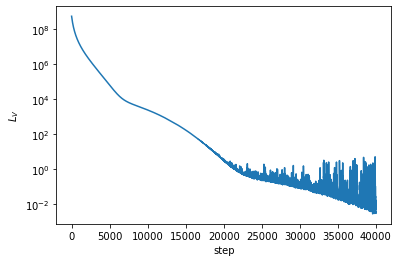

In [9]:
plt.figure(1)
plt.plot(loss_history)
plt.yscale('log')
plt.xlabel('step')
plt.ylabel('$L_{V}$')
plt.show()

<Figure size 432x288 with 0 Axes>

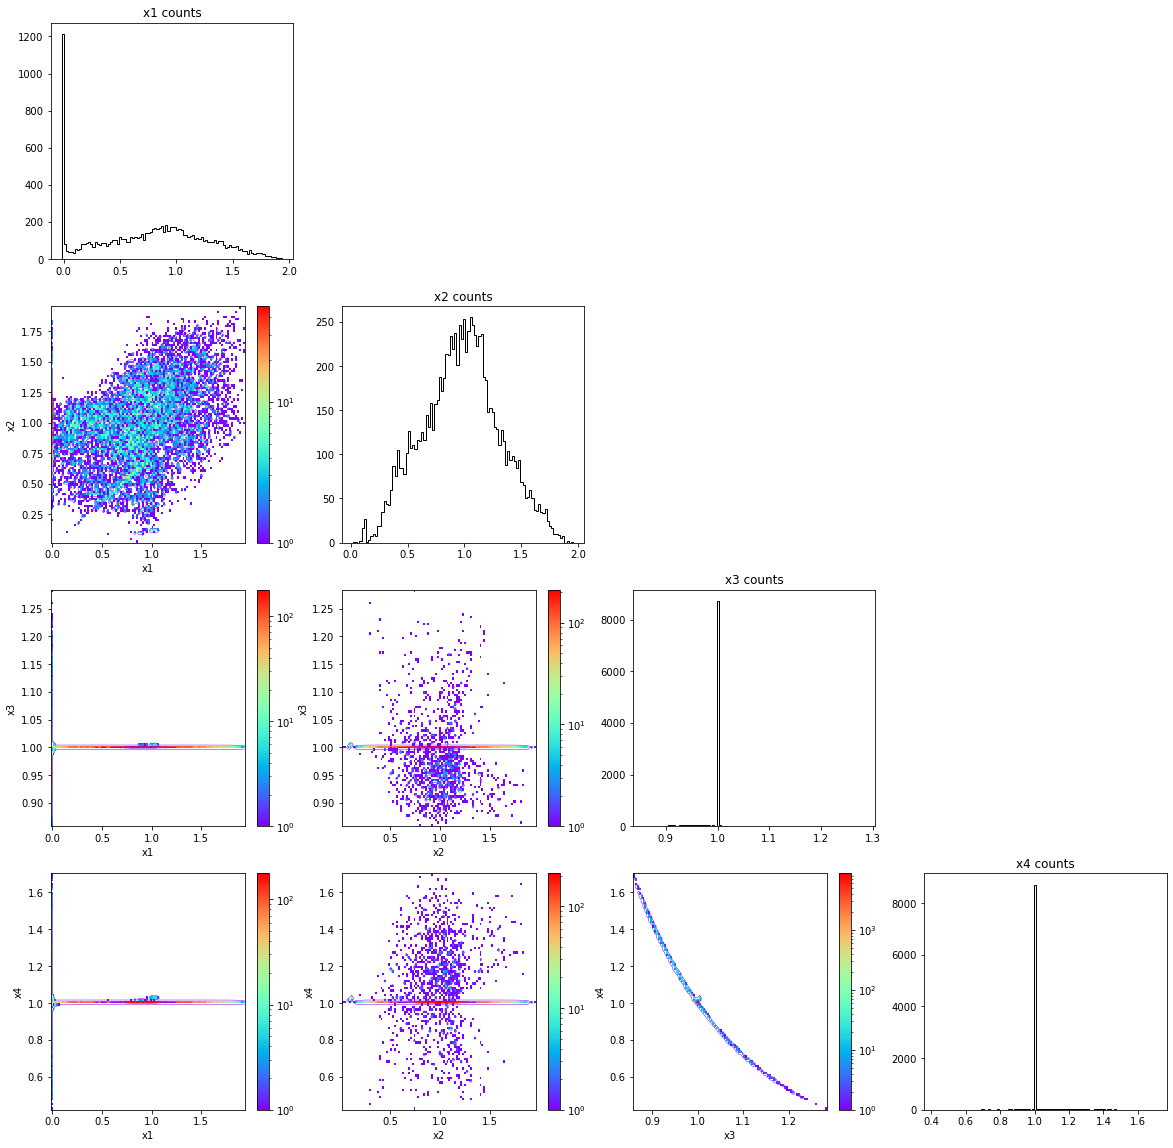

In [10]:
plt.figure(1)
triangular_plot(x.numpy())


In [11]:
xnp = x.numpy()

xnpfiltered=xnp[np.abs(1-xnp[:,3])>0.01]
xnpfiltered.shape

xnpfiltered2=xnp[np.abs(1-xnp[:,3])<=0.01]
xnpfiltered2.shape

(8714, 4)

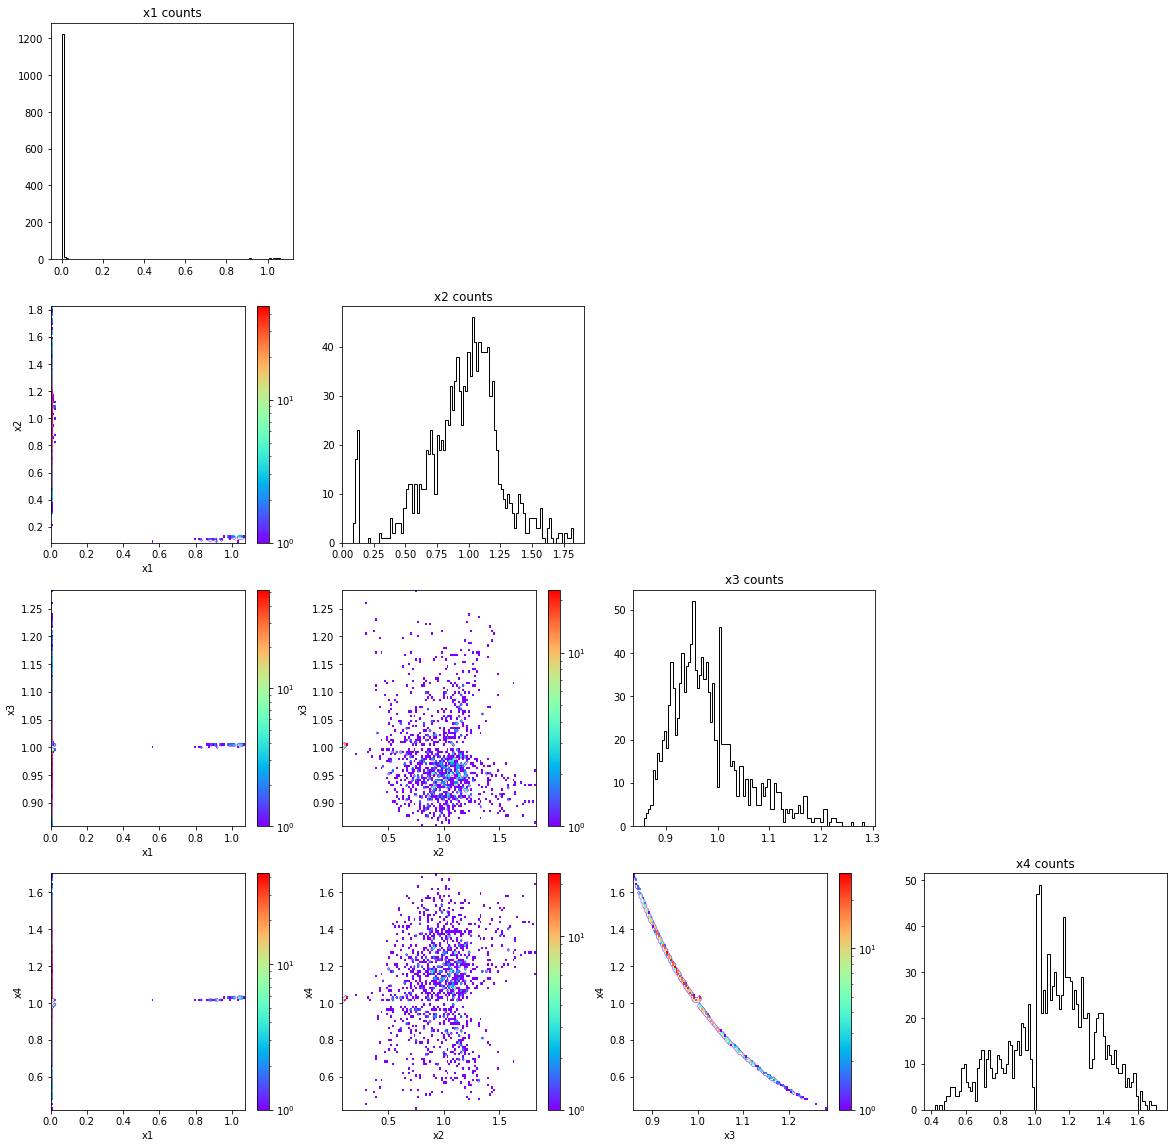

In [12]:
triangular_plot(xnpfiltered)

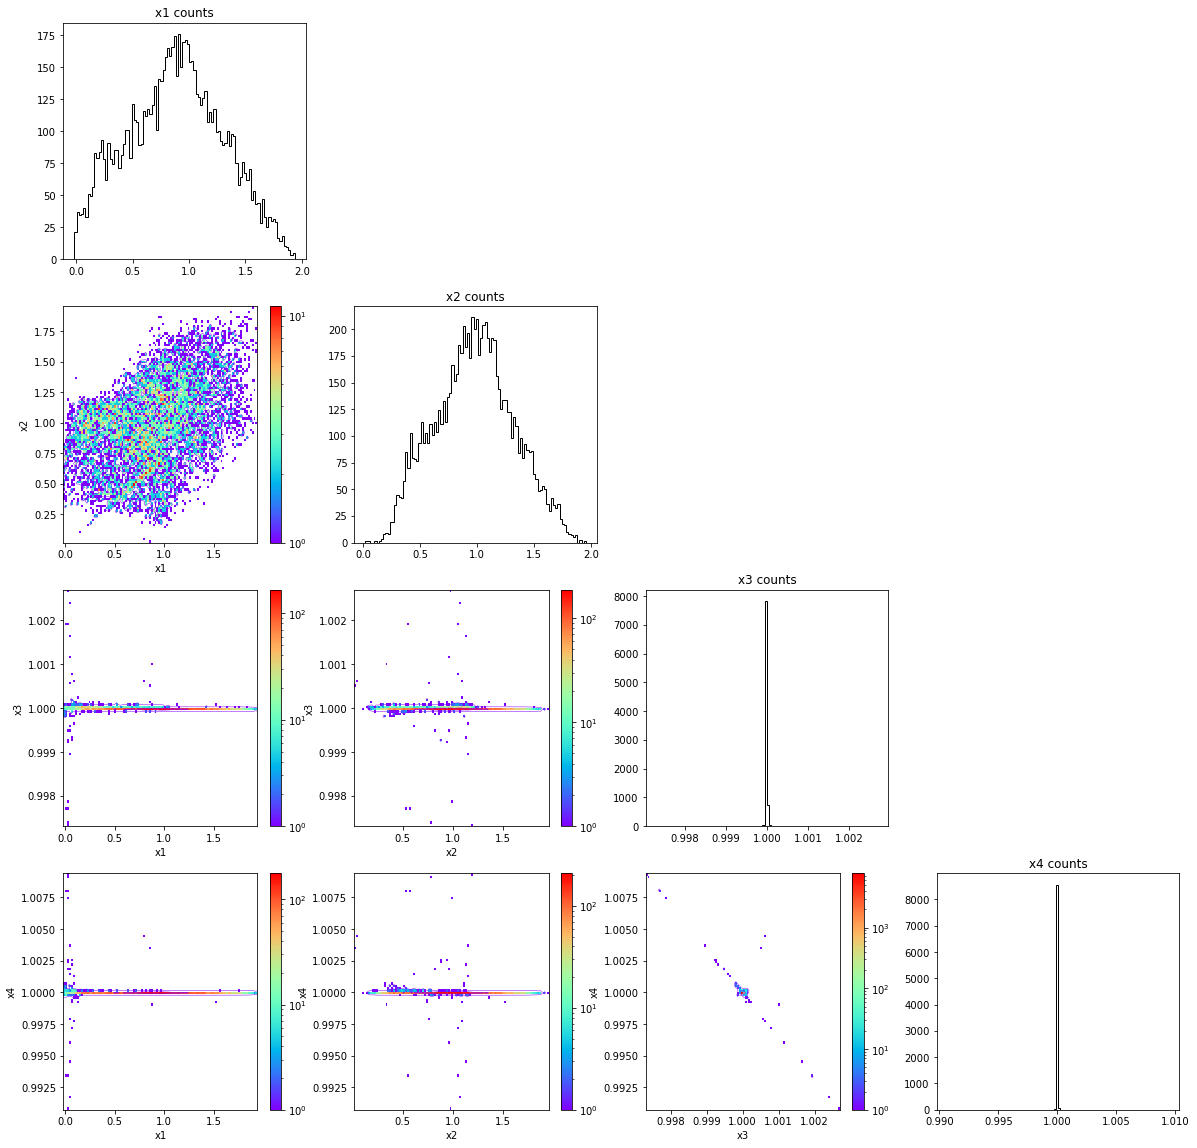

In [13]:
triangular_plot(xnpfiltered2)

## Autoencoder

In [5]:
import os
from importlib.machinery import SourceFileLoader


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model

In [6]:
# Loading the potential
potential = "pot_4_param_log"                         # .py file with potential function V(x)
module = SourceFileLoader(potential,os.getcwd()+'/Potential_generator/'+potential+'.py').load_module()
V = module.V
dim = module.dim


out_dir = os.getcwd()+'/Output/'
time = '2024_12_05_at_07_31_26'
n_points = 10000

attempt = f"_{potential}_{n_points}_{time}"

data_file = out_dir + 'Points' + attempt + '.npy'
loss_file = out_dir + 'Loss' + attempt + '.npy'

In [7]:
x = np.load(data_file)
loss_history = np.load(loss_file)

In [8]:
x_train, x_test = train_test_split(x, test_size=0.15, random_state=42)

In [9]:
print(f'shape of total set of points: {x.shape}')
print(f'shape of training set of points: {x_train.shape}')
print(f'shape of validation set of points: {x_test.shape}')

shape of total set of points: (10000, 4)
shape of training set of points: (8500, 4)
shape of validation set of points: (1500, 4)


### Latent dimension = 1

In [10]:
input_dim = dim  
latent_dim = 1  

# Encoder
inputs = layers.Input(shape=(input_dim,))
encoded = layers.Dense(32, activation='sigmoid')(inputs)
encoded = layers.Dense(16, activation='sigmoid')(encoded)
encoded = layers.Dense(8, activation='sigmoid')(encoded)
encoded = layers.Dense(latent_dim)(encoded)  

# Decoder
decoded = layers.Dense(8, activation='sigmoid')(encoded)
decoded = layers.Dense(16, activation='sigmoid')(decoded)
decoded = layers.Dense(32, activation='sigmoid')(decoded)
decoded = layers.Dense(input_dim)(decoded)  

# Autoencoder 
autoencoder = models.Model(inputs, decoded)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
autoencoder.compile(optimizer=optimizer, loss='mse')

I0000 00:00:1733854269.080455    7698 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733854269.160751    7698 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733854269.161048    7698 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733854269.163115    7698 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [11]:
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │            16 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,669 (6.52 KB)

 Trainable params: 1,669 (6.52 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
epochs = 3000
history_AE_1 = autoencoder.fit(x_train, x_train, epochs=epochs, batch_size=100, shuffle=True,validation_data=(x_test, x_test))

Epoch 1/3000


I0000 00:00:1733854282.719575    7797 service.cc:146] XLA service 0x78d020003e40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733854282.719596    7797 service.cc:154]   StreamExecutor device (0): Quadro T2000 with Max-Q Design, Compute Capability 7.5
2024-12-10 19:11:22.769425: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-10 19:11:22.986930: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


64/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1473

I0000 00:00:1733854284.699928    7797 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.1251 - val_loss: 0.8857
Epoch 2/3000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8171 - val_loss: 0.6400
Epoch 3/3000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5871 - val_loss: 0.4595
Epoch 4/3000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4215 - val_loss: 0.3298
Epoch 5/3000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3044 - val_loss: 0.2394
Epoch 6/3000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2222 - val_loss: 0.1788
Epoch 7/3000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1686 - val_loss: 0.1403
Epoch 8/3000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1328 - val_loss: 0.1170
Epoch 9/3000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1130 - val_loss: 0.1039
Epoch 10/3000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0997 - val_loss: 0.0970
Epoch 11/3000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0961 - val_loss: 0.0936
Epoch 12/3000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.09

In [13]:
autoencoder_1 = autoencoder
encoder_1 = models.Model(inputs,encoded)
decoder_1 = models.Model(encoded,decoded)

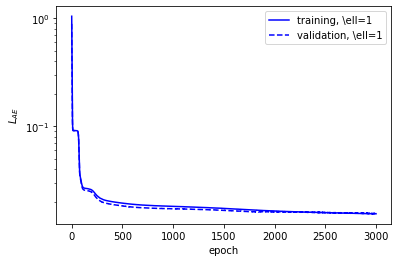

In [14]:
plt.plot(history_AE_1.history['loss'], label='training, \ell=1',color='blue')
plt.plot(history_AE_1.history['val_loss'], label='validation, \ell=1',color='blue',linestyle='--')
plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('$L_{AE}$')
plt.legend()

### Latent dimension = 2

In [15]:
input_dim = dim  
latent_dim = 2

# Encoder
inputs = layers.Input(shape=(input_dim,))
encoded = layers.Dense(32, activation='sigmoid')(inputs)
encoded = layers.Dense(16, activation='sigmoid')(encoded)
encoded = layers.Dense(8, activation='sigmoid')(encoded)
encoded = layers.Dense(latent_dim)(encoded)  

# Decoder
decoded = layers.Dense(8, activation='sigmoid')(encoded)
decoded = layers.Dense(16, activation='sigmoid')(decoded)
decoded = layers.Dense(32, activation='sigmoid')(decoded)
decoded = layers.Dense(input_dim)(decoded)  

# Autoencoder 
autoencoder = models.Model(inputs, decoded)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
autoencoder.compile(optimizer=optimizer, loss='mse')

In [16]:
autoencoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 8)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,686 (6.59 KB)

 Trainable params: 1,686 (6.59 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
epochs = 3000
history_AE_2 = autoencoder.fit(x_train, x_train, epochs=epochs, batch_size=100, shuffle=True,validation_data=(x_test, x_test))

Epoch 1/3000
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 1.2870 - val_loss: 0.9981
Epoch 2/3000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9111 - val_loss: 0.7027
Epoch 3/3000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6368 - val_loss: 0.4896
Epoch 4/3000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4475 - val_loss: 0.3413
Epoch 5/3000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3124 - val_loss: 0.2421
Epoch 6/3000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2222 - val_loss: 0.1784
Epoch 7/3000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1670 - val_loss: 0.1392
Epoch 8/3000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1334 - val_loss: 0.1163
Epoch 9/3000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1110 - val_loss: 0.1036
Epoch 10/3000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1013 - val_loss: 0.0969
Epoch 11/3000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0952 - val_loss: 0.0936
Epoch 12/3000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

In [18]:
autoencoder_2 = autoencoder
encoder_2 = models.Model(inputs,encoded)
decoder_2 = models.Model(encoded,decoded)

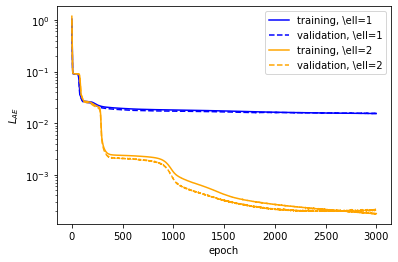

In [19]:
plt.plot(history_AE_1.history['loss'], label='training, \ell=1',color='blue')
plt.plot(history_AE_1.history['val_loss'], label='validation, \ell=1',color='blue',linestyle='--')
plt.plot(history_AE_2.history['loss'], label='training, \ell=2',color='orange')
plt.plot(history_AE_2.history['val_loss'], label='validation, \ell=2',color='orange',linestyle='--')
plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('$L_{AE}$')
plt.legend()

In [20]:
# test autoencoder
encoded_points = encoder_2.predict(x_test)

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


### Latent dimension = 3

In [21]:
input_dim = dim  
latent_dim = 3

# Encoder
inputs = layers.Input(shape=(input_dim,))
encoded = layers.Dense(32, activation='sigmoid')(inputs)
encoded = layers.Dense(16, activation='sigmoid')(encoded)
encoded = layers.Dense(8, activation='sigmoid')(encoded)
encoded = layers.Dense(latent_dim)(encoded)  

# Decoder
decoded = layers.Dense(8, activation='sigmoid')(encoded)
decoded = layers.Dense(16, activation='sigmoid')(decoded)
decoded = layers.Dense(32, activation='sigmoid')(decoded)
decoded = layers.Dense(input_dim)(decoded)  

# Autoencoder 
autoencoder = models.Model(inputs, decoded)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
autoencoder.compile(optimizer=optimizer, loss='mse')

In [22]:
autoencoder.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 3)              │            27 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 8)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,703 (6.65 KB)

 Trainable params: 1,703 (6.65 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
epochs = 3000
history_AE_3 = autoencoder.fit(x_train, x_train, epochs=epochs, batch_size=100, shuffle=True,validation_data=(x_test, x_test))

Epoch 1/3000


85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 2.2154 - val_loss: 1.8436
Epoch 2/3000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7320 - val_loss: 1.4297
Epoch 3/3000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3396 - val_loss: 1.0972
Epoch 4/3000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0175 - val_loss: 0.8331
Epoch 5/3000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7749 - val_loss: 0.6262
Epoch 6/3000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5803 - val_loss: 0.4671
Epoch 7/3000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4340 - val_loss: 0.3476
Epoch 8/3000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3208 - val_loss: 0.2604
Epoch 9/3000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2364 - val_loss: 0.1989
Epoch 10/3000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1851 - val_loss: 0.1571
Epoch 11/3000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1491 - val_loss: 0.1298
Epoch 12/3000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.12

In [24]:
autoencoder_3 = autoencoder
encoder_3 = models.Model(inputs,encoded)
decoder_3 = models.Model(encoded,decoded)

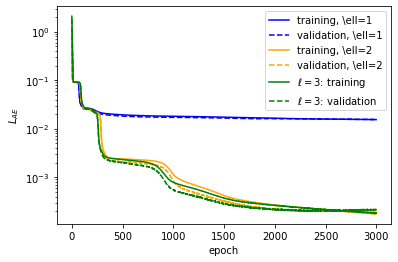

In [25]:
plt.plot(history_AE_1.history['loss'], label='training, \ell=1',color='blue')
plt.plot(history_AE_1.history['val_loss'], label='validation, \ell=1',color='blue',linestyle='--')
plt.plot(history_AE_2.history['loss'], label='training, \ell=2',color='orange')
plt.plot(history_AE_2.history['val_loss'], label='validation, \ell=2',color='orange',linestyle='--')
plt.plot(history_AE_3.history['loss'], label='$\ell=3$: training',color='green')
plt.plot(history_AE_3.history['val_loss'], label='$\ell=3$: validation',color='green',linestyle='--')

plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('$L_{AE}$')
plt.legend()

plt.show()

# plt.savefig('../LaTeX/Notes/Figures/lossAE_higgs.png')

### Latent dimension = 4

In [26]:
input_dim = dim  
latent_dim = 4

# Encoder
inputs = layers.Input(shape=(input_dim,))
encoded = layers.Dense(32, activation='sigmoid')(inputs)
encoded = layers.Dense(16, activation='sigmoid')(encoded)
encoded = layers.Dense(8, activation='sigmoid')(encoded)
encoded = layers.Dense(latent_dim)(encoded)  

# Decoder
decoded = layers.Dense(8, activation='sigmoid')(encoded)
decoded = layers.Dense(16, activation='sigmoid')(decoded)
decoded = layers.Dense(32, activation='sigmoid')(decoded)
decoded = layers.Dense(input_dim)(decoded)  

# Autoencoder 
autoencoder = models.Model(inputs, decoded)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
autoencoder.compile(optimizer=optimizer, loss='mse')

In [27]:
autoencoder.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,720 (6.72 KB)

 Trainable params: 1,720 (6.72 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
epochs = 3000
history_AE_4 = autoencoder.fit(x_train, x_train, epochs=epochs, batch_size=100, shuffle=True,validation_data=(x_test, x_test))

Epoch 1/3000
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.2343 - val_loss: 0.1482
Epoch 2/3000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1317 - val_loss: 0.1032
Epoch 3/3000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0968 - val_loss: 0.0927
Epoch 4/3000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0923 - val_loss: 0.0911
Epoch 5/3000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0895 - val_loss: 0.0910
Epoch 6/3000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0906 - val_loss: 0.0909
Epoch 7/3000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0914 - val_loss: 0.0909
Epoch 8/3000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0918 - val_loss: 0.0909
Epoch 9/3000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0913 - val_loss: 0.0909
Epoch 10/3000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0906 - val_loss: 0.0910
Epoch 11/3000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0910 - val_loss: 0.0910
Epoch 12/3000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

In [29]:
autoencoder_4 = autoencoder
encoder_4 = models.Model(inputs,encoded)
decoder_4 = models.Model(encoded,decoded)

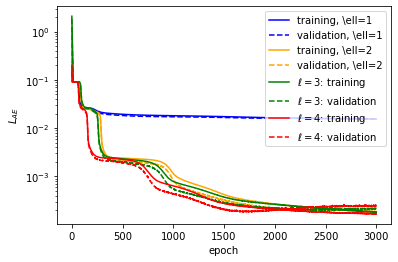

In [31]:
plt.plot(history_AE_1.history['loss'], label='training, \ell=1',color='blue')
plt.plot(history_AE_1.history['val_loss'], label='validation, \ell=1',color='blue',linestyle='--')
plt.plot(history_AE_2.history['loss'], label='training, \ell=2',color='orange')
plt.plot(history_AE_2.history['val_loss'], label='validation, \ell=2',color='orange',linestyle='--')
plt.plot(history_AE_3.history['loss'], label='$\ell=3$: training',color='green')
plt.plot(history_AE_3.history['val_loss'], label='$\ell=3$: validation',color='green',linestyle='--')
plt.plot(history_AE_4.history['loss'], label='$\ell=4$: training',color='red')
plt.plot(history_AE_4.history['val_loss'], label='$\ell=4$: validation',color='red',linestyle='--')

plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('$L_{AE}$')
plt.legend()

plt.show()

# plt.savefig('../LaTeX/Notes/Figures/lossAE_higgs.png')